# Table of Contents

1. [Data Preparation](#preparation)
2. [Data Exploration & Feature Selection](#exploration)
3. [Model Fitting & Tunning](#fitting)
4. [Model Performance Validation](#validation)

This notebook contains steps in building a XGBoost classifying model with the aim of categorizing compliant and non-compliant Detroit blight tickets. The dataset contains information regarding 250K blight tickets issued in past couple of decades. 

Features included in the dataset are:

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
pd.set_option('display.max_columns', 40)

In [66]:
df_ori = pd.read_csv('train.csv',
                         encoding="ISO-8859-1",
                         dtype={
                             'zip_code': 'object',
                             'non_us_str_code': 'object',
                             'grafitti_status': 'object'
                         })

In [67]:
# Load violator's addresses and their coordinates
add = pd.read_csv('addresses.csv')
geo = pd.read_csv('latlons.csv')

<a name="preparation"></a>
## 1. Data Preparation

In [68]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [69]:
df_ori.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [70]:
add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ticket_id  311307 non-null  int64 
 1   address    311307 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB


In [71]:
add.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [72]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121769 entries, 0 to 121768
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  121769 non-null  object 
 1   lat      121762 non-null  float64
 2   lon      121762 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


In [73]:
geo.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


The geo dataframe contains geo-coordinates of addresses appeared in the dataset. Merging coordinates with the address dataframe on addresses.

In [74]:
print(add.shape)
add = add.merge(geo, how='inner', on='address')
add.shape

(311307, 2)


(311307, 4)

The merged address dataframe shares a common key 'ticket_id' with the ticket dataframe. Merging the two dataframes based on ticket id to form a master.

In [75]:
# merge the tickets dataframe with the address dataframe
print(df_ori.shape)
df = df_ori.merge(add, how='inner', on='ticket_id')
df.shape

(250306, 34)


(250306, 37)

In [76]:
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [77]:
# drop rows with compliance status - NaN. These are the people who were later found to be not responsible.
print(df.shape)
df.dropna(axis=0, subset=['compliance'], inplace=True)
df.shape

(250306, 37)


(159880, 37)

In [78]:
# check for duplicated rows in the data
df.duplicated().any()

False

Split the dataset into training and validation sets.

In [79]:
from sklearn.model_selection import train_test_split

def x_y_split(df, target='compliance'):
    """separates X and Y variables from df, returns X as dataframe y as series"""
    X = df.loc[:, df.columns != target].reset_index(drop=True)
    y = df[target].reset_index(drop=True)
    return X,y

X, y = x_y_split(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y )


# add y_train column back to df for data exploration
df = X_train.assign(compliance=y_train)

In [80]:
print(X_test.shape)
df.shape

(31976, 36)


(127904, 37)

### During the preparation stage, three dataframes were merged into one. The ticket dataframe now contains geo coordinates for addresses of violations. 20% of the data is set aside for validation purposes and the model will be developed on the remaining data using K-fold cross-validation.

<a name='exploration'></a>
## 2. Data Exploration & Feature Selection

In [81]:
# drop columns in the training dataset that are not avaiable when making predictions 

to_drop = ['payment_amount', 'balance_due', 'payment_date', 'payment_status',
          'collection_status', 'compliance_detail']
print(df.shape)
df.drop(columns=to_drop, inplace=True)
df.shape

(127904, 37)


(127904, 31)

In [82]:
# drop columns that contain redundant information or are difficult to interpret by the classifier 

to_drop = ['ticket_id', 'inspector_name', 'violation_street_number', 'violation_street_name', 
           'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name',
           'city', 'state', 'zip_code', 'non_us_str_code', 'violation_description', 'address']
print(df.shape)
df.drop(columns=to_drop, inplace=True)
df.shape
           

(127904, 31)


(127904, 18)

### 2.1 Latitude and Longitude

Visualize coordinates of addresses in a scatter plot and see if there are any outliers

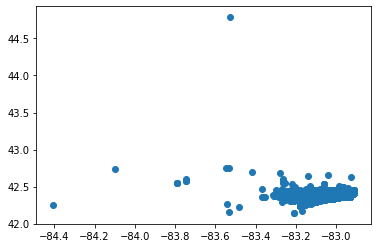

In [83]:
plt.scatter(df['lon'], df['lat'])

Since there are multiple outliers, this plot will focus on the data points within the boundary of Detroit.

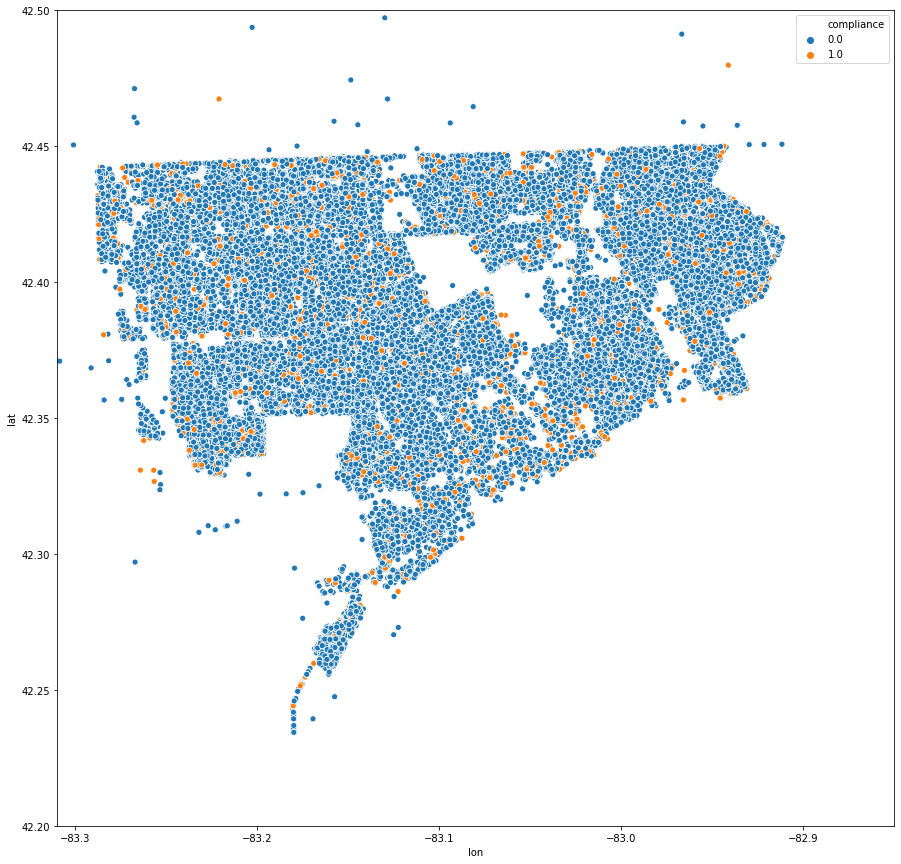

In [84]:
plt.figure(figsize=(15,15))
sns.scatterplot(df['lon'], df['lat'], hue=df['compliance'])
plt.xlim((-83.31, -82.85))
plt.ylim((42.2, 42.5));

It appears most observations are non-compliant and there seems to be a lot of overlapping points in the plot. A heatmap showing the percentage of compliant tickets could better reveal areas with higher chances of compliance.

In [85]:
# dividing coordinates into zones and use zones as categorical variable when training

# each zone is roughly 1.5km by 1.5km
bins_lat = np.arange(42.20, 42.57, 0.015) 
bins_lon = np.arange(-83.31, -82.87, 0.015)

def cut_coordinates_into_bins(df, lat_bins, lon_bins):
    """cut coordinates into bins according to given bin sizes. Out of range values are put into a single bin"""
    
    lat_cut = pd.cut(df['lat'], bins=lat_bins).astype(str)
    lon_cut = pd.cut(df['lon'], bins=lon_bins).astype(str)
    new_df = df.assign(lat_cut=lat_cut, lon_cut=lon_cut)
    
    na_index = new_df[(new_df[['lat_cut', 'lon_cut']] == 'nan').any(axis=1)].index

    new_df.loc[na_index, ['lat_cut', 'lon_cut']] = 'out of bounds'
    return new_df
    

In [86]:
df = cut_coordinates_into_bins(df, bins_lat, bins_lon)

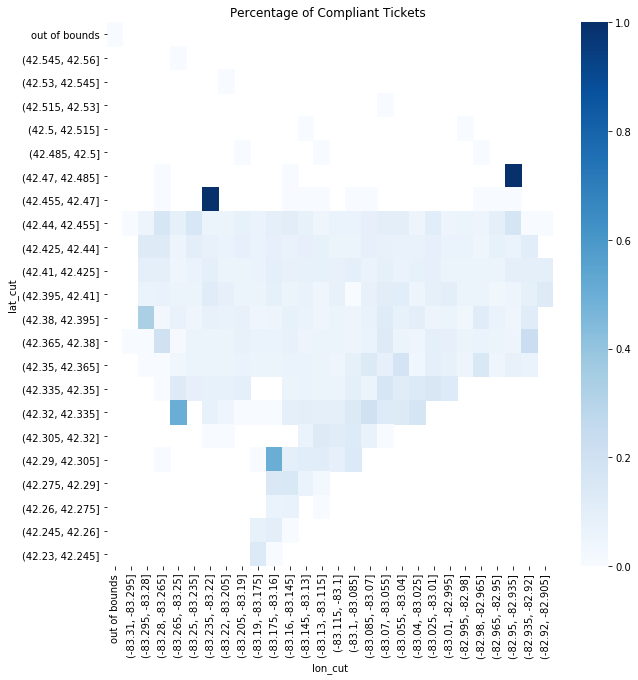

In [87]:
# create a heatmap based on percentage of obs that are compliant

res = df.groupby(['lat_cut', 'lon_cut'])['compliance'].mean().unstack()

plt.figure(figsize=(10,10))
sns.heatmap(res.iloc[::-1, ::-1],cmap="Blues")
plt.title('Percentage of Compliant Tickets ');

There are areas where the percentages of compliant tickets are higher than surrounding areas, as shown in the upper and lower right of the graph. This geographical difference in compliant chance could indicate ``lon`` and ``lat`` to be good predictors for the model.

### 2.2 Issue Time and Hearing Time

Examine if the month when the tickets were issued or would be heard has an influence on the outcome of the ticket.

In [88]:
# convert issue and hearing date to datatime objects

df['ticket_issued_date'] = pd.to_datetime(df['ticket_issued_date'])
df['hearing_date'] = pd.to_datetime(df['hearing_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127904 entries, 85445 to 125705
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   agency_name         127904 non-null  object        
 1   violator_name       127879 non-null  object        
 2   country             127904 non-null  object        
 3   ticket_issued_date  127904 non-null  datetime64[ns]
 4   hearing_date        127716 non-null  datetime64[ns]
 5   violation_code      127904 non-null  object        
 6   disposition         127904 non-null  object        
 7   fine_amount         127904 non-null  float64       
 8   admin_fee           127904 non-null  float64       
 9   state_fee           127904 non-null  float64       
 10  late_fee            127904 non-null  float64       
 11  discount_amount     127904 non-null  float64       
 12  clean_up_cost       127904 non-null  float64       
 13  judgment_amount     12790

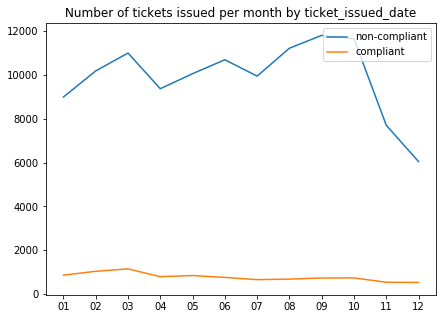

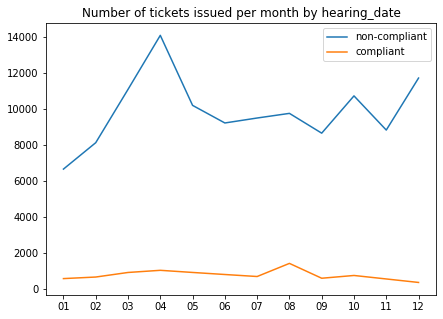

In [89]:
com = df.loc[df['compliance'] ==1, :]
non_com = df.loc[df['compliance'] ==0, :]


def plot_issue_hearing_counts(data, cat):
    """takes a dataframe and plot the number of compliant and non-comp tickets for each month. Ticket type is specified by cat."""
    
    levels = data[cat].dt.strftime('%m')
    freq = data.groupby([levels, 'compliance']).count()['agency_name'].unstack()
    
    plt.plot(freq.index, freq[0], label='non-compliant')
    plt.plot(freq.index, freq[1], label='compliant')
    plt.legend(loc='upper right')
    plt.title('Number of tickets issued per month by {}'.format(cat))


    

plt.figure(figsize=(7, 5))  
plot_issue_hearing_counts(df, 'ticket_issued_date')

plt.figure(figsize=(7, 5))
plot_issue_hearing_counts(df, 'hearing_date')

There is no significant difference between the trend of compliant and non-compliant tickets issuance from month to month. The number of compliant tickets goes up and down with the number of non-compliant tickets, albeit on a smaller scale.

The time difference between issuance and hearing date can be calculated. An violator's tendency to comply might be influenced by the the number of days till hearing (e.g. people might be more inclined to pay if the hearing day is close)

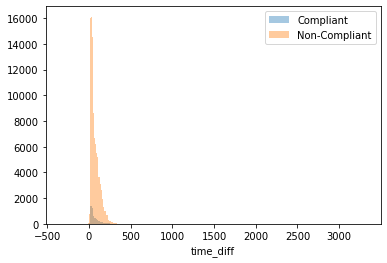

In [90]:
df['time_diff'] = df['hearing_date'] - df['ticket_issued_date']
df['time_diff'] = df['time_diff'] / np.timedelta64(1, 'D')

def plot_time_diff_hist(df, compliant=False, both=True):
    """plot a histogram of time difference"""
    com = df[df['compliance'] ==1]
    non_com = df[df['compliance'] ==0]
    bins = np.arange(df['time_diff'].min(), df['time_diff'].max()+10, 10)
    cp = sns.color_palette()
    
    if compliant:
        sns.distplot(com['time_diff'], kde=False, bins=bins, label='Compliant', color=cp[0])
    elif both:
        sns.distplot(com['time_diff'], kde=False, bins=bins, label='Compliant')
        sns.distplot(non_com['time_diff'], kde=False, bins=bins, label='Non-Compliant')
    else:
        sns.distplot(non_com['time_diff'], kde=False, bins=bins, label='Non-Compliant', color=cp[1])
    plt.legend(loc='upper right')
    
    

plot_time_diff_hist(df,both=True)
#plt.xlim(0,500);



Number of days between issuing and hearing takes on a huge range of numbers with some even being negative. For tickets with a hearing date earlier than issuing date, the two dates might be recorded in the wrong order (the hearing date might have been the issuing date).

In [91]:
df['time_diff'].describe()

count    127716.000000
mean         72.958202
std          58.241654
min        -336.125000
25%          31.000000
50%          54.241319
75%         100.173611
max        3307.020833
Name: time_diff, dtype: float64

In [92]:
def preprocess_time_diff(df):
    """Calculates absolute values of time difference, stores in time_diff column and returns df"""
    time_diff = df['time_diff'].copy(deep=True)
    diff = time_diff.apply(abs)
    new_df = df.drop(columns='time_diff')
    new_df = new_df.assign(time_diff=diff)
    return new_df

In [93]:
df = preprocess_time_diff(df)

In [94]:
df['time_diff'].describe()

count    127716.000000
mean         73.084215
std          58.083448
min           0.000000
25%          31.009549
50%          54.250000
75%         100.197917
max        3307.020833
Name: time_diff, dtype: float64

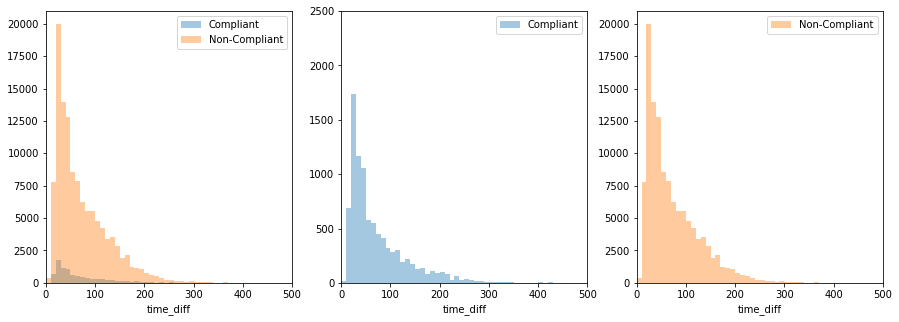

In [95]:
#plot has a few outliers, zoom in on between 0, 500 to see the bulk of datapoints
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_time_diff_hist(df)
plt.xlim(0,500);

#zoom in on compliant tickets
plt.subplot(1,3,2)
plot_time_diff_hist(df, compliant=True, both=False)
plt.xlim(0,500)
plt.ylim(0,2500);

plt.subplot(1,3,3)
plot_time_diff_hist(df, compliant=False, both=False)
plt.xlim(0,500);


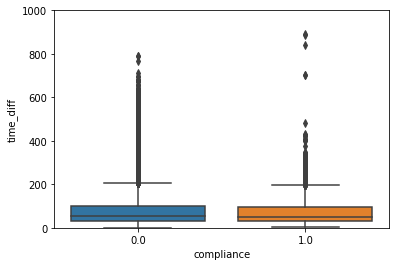

In [96]:
sns.boxplot(y='time_diff', x='compliance', data=df)
plt.ylim(0,1000);

Although the mean time difference for compliant and non-compliant tickets are similar, almost all compliant tickets have hearing scheduled less than 500 days from the issuance, whereas there are a number of non-compliant tickets with ``time_diff`` longer than 500. This difference indicates the time difference between issuing and hearing could have an impact on the outcome of a ticket.

### 2.3 Issuing Agency

In [97]:
# the percentages of all tickets that are compliant by issuing agency name

perc = df.groupby(['agency_name']).mean()['compliance']
perc

agency_name
Buildings, Safety Engineering & Env Department    0.060365
Department of Public Works                        0.090515
Detroit Police Department                         0.133539
Health Department                                 0.065913
Name: compliance, dtype: float64

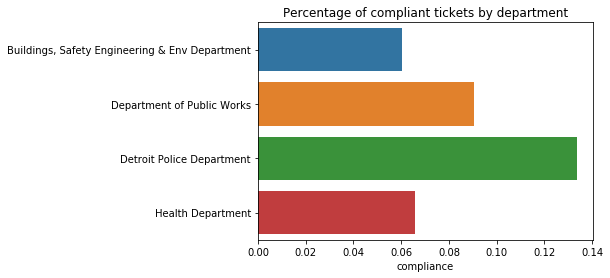

In [98]:
sns.barplot(y=list(perc.index), x=perc)
plt.title('Percentage of compliant tickets by department');

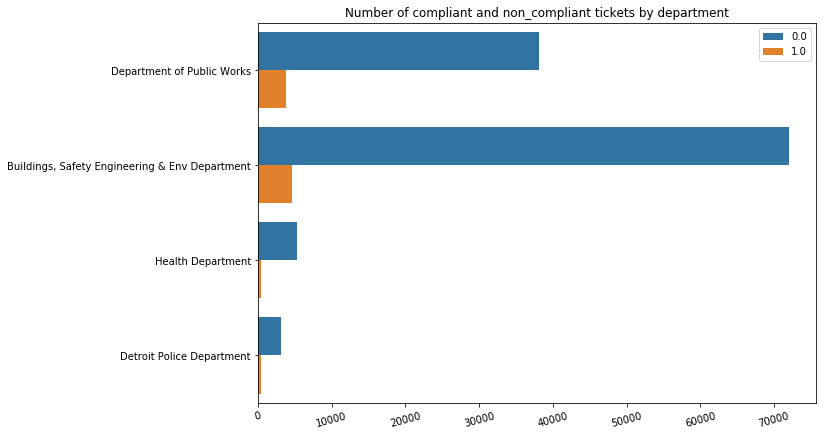

In [99]:
plt.figure(figsize=(10,7))
sns.countplot(y='agency_name', hue='compliance', data=df)
plt.legend(loc='upper right')
plt.xticks(rotation=15)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of compliant and non_compliant tickets by department');

It appears the issuing agency does have an effect on compliance rate. Tickets issued by the police department have the highest compliance rate whereas Buildings, Safety Engineering & Env Department has the lowest.

### 2.4 Violator Name

In [100]:
counts = df['violator_name'].value_counts()
counts[counts >= 30]

INVESTMENT, ACORN                    501
INVESTMENT CO., ACORN                269
BANK, WELLS FARGO                    195
MILLER, JOHN                         149
STEHLIK, JERRY                       122
                                    ... 
SHIFMAN, ALLEN                        31
PARKVIEW LLC, NORMANDY                30
HOBBS, JAMES                          30
COMPANY, DETROIT LEASING              30
DEVELOPMENT, DETROIT NEIGHBORHOOD     30
Name: violator_name, Length: 96, dtype: int64

In [101]:
# keep violators with 30 or more violations and the remaining will be categorized as 'others'

# there seems to be different spellings for the same organization (e.g. Acorn), replace these names with a common name


def replace_violator_name(df):
    """replace different spellings of an violator's name with one, returns a list of violator names"""
    names = pd.Series(df['violator_name'].unique(), dtype='string')
    acorn = names[names.str.contains('acorn', flags=re.IGNORECASE, regex=True, na=False)]
    wellsfargo = names[names.str.contains('wells.*fargo|fargo.*wells', flags=re.IGNORECASE, regex=True, na=False)]
    deutsche = names[names.str.contains('deutsche.*bank|bank.*deutsche', flags=re.IGNORECASE, regex=True, na=False)]
    morgan = names[names.str.contains('JP.*Morgan|Morgan.*JP', flags=re.IGNORECASE, regex=True, na=False)]
   
    to_replace = [acorn.values, wellsfargo.values, deutsche.values, morgan.values]
    one_name = ['INVESTMENT CO., ACORN', 'BANK, WELLS FARGO', 
            'NATIONAL TRUST CO., DEUTSCHE BANK', 'CHASE BANK, JP MORGAN']
    
    violator_name = df['violator_name'].copy(deep=True)
    for n,c in zip(one_name, to_replace):
        violator_name = violator_name.replace(c, n, regex=False)
    return violator_name

def preprocess_violator_name(df, violatorname):
    """replace violators appearing less than 40 times with 'others', returns changed dataframe """
    vc = violatorname.value_counts()
    to_keep = list(vc[vc >= 30].index)
    dropped = list(vc[vc < 30].index)
    new_violator_name = np.where(violatorname.isin(to_keep), violatorname, 'other')
    df_new = df.drop(columns='violator_name')
    df_new = df_new.assign(violator_name=new_violator_name)
    return df_new, dropped

In [102]:
violator_name = replace_violator_name(df)
df, dropped = preprocess_violator_name(df, violator_name)

In [103]:
df['violator_name'].value_counts()

other                                121543
INVESTMENT CO., ACORN                  1289
BANK, WELLS FARGO                       630
NATIONAL TRUST CO., DEUTSCHE BANK       603
MILLER, JOHN                            149
                                      ...  
HAIDAR, ALI                              31
PARKVIEW LLC, NORMANDY                   30
HOBBS, JAMES                             30
DEVELOPMENT, DETROIT NEIGHBORHOOD        30
COMPANY, DETROIT LEASING                 30
Name: violator_name, Length: 85, dtype: int64

In [104]:
#  check for missing values
df.isna().sum()

agency_name                0
country                    0
ticket_issued_date         0
hearing_date             188
violation_code             0
disposition                0
fine_amount                0
admin_fee                  0
state_fee                  0
late_fee                   0
discount_amount            0
clean_up_cost              0
judgment_amount            0
grafitti_status       127904
lat                        0
lon                        0
compliance                 0
lat_cut                    0
lon_cut                    0
time_diff                188
violator_name              0
dtype: int64

### 2.5 Numeric Features

In [105]:
numeric = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 
          'discount_amount', 'clean_up_cost', 'judgment_amount']
df_num = df[numeric]
y = df['compliance']

In [106]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold().fit(df_num)
selector.variances_

array([10000.        ,     0.        ,     0.        ,  1000.        ,
          14.44194545,     0.        , 11030.        ])

``Admin_fee``, ``state_fee`` and ``clean_up_cost`` have 0 variances. They will be dropped

<a name='fitting'></a>
## 3. Model Fitting & Tuning

In [107]:
X_train, y_train = x_y_split(df)

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127904 entries, 0 to 127903
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   agency_name         127904 non-null  object        
 1   country             127904 non-null  object        
 2   ticket_issued_date  127904 non-null  datetime64[ns]
 3   hearing_date        127716 non-null  datetime64[ns]
 4   violation_code      127904 non-null  object        
 5   disposition         127904 non-null  object        
 6   fine_amount         127904 non-null  float64       
 7   admin_fee           127904 non-null  float64       
 8   state_fee           127904 non-null  float64       
 9   late_fee            127904 non-null  float64       
 10  discount_amount     127904 non-null  float64       
 11  clean_up_cost       127904 non-null  float64       
 12  judgment_amount     127904 non-null  float64       
 13  grafitti_status     0 non-nul

In [109]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
import xgboost as xgb

to_drop = ['admin_fee', 'state_fee', 'clean_up_cost', 'lat', 
           'lon', 'grafitti_status', 'ticket_issued_date', 'hearing_date']

num_features = ['fine_amount', 'late_fee', 'discount_amount', 
                    'judgment_amount', 'time_diff']

cat_features = ['agency_name', 'country', 'violation_code', 'disposition',
                 'lat_cut', 'lon_cut', 'violator_name']

one_hot = OneHotEncoder(handle_unknown='ignore')
rs = RobustScaler()
imp = SimpleImputer()

num_trans = Pipeline(steps=[('imputer', imp),
])

cat_trans = Pipeline(steps=[
    ('onehot', one_hot)
])

preprocessor = ColumnTransformer([('num', num_trans, num_features),
                                  ('cat', cat_trans, cat_features),
                                  ('to_drop','drop', to_drop)],
                                 remainder='passthrough')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', nthread=1, seed=0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', xgb_model)])



In [ ]:
param_dist = {
    'classifier__n_estimators': [500, 600, 700, 800],  #4
    'classifier__learning_rate': np.arange(0.04, 0.12, 0.02),  #4
    'classifier__max_depth': [5, 6, 7, 8],  #4
    'classifier__subsample': [0.6, 0.8, 1],  # 3
    'classifier__gamma': [0.5, 1, 2, 5],  # 4
    'classifier__colsample_bytree': np.arange(0.4, 1.2, 0.2)
}  #4

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
rand_search = RandomizedSearchCV(clf,
                                 param_distributions=param_dist,
                                 n_iter=100,
                                 cv=skf.split(X_train, y_train),
                                 scoring='roc_auc',
                                 n_jobs=10,
                                 verbose=10,
                                 random_state=0)
rand_search.fit(X_train, y_train)

In [ ]:
print(rand_search.best_params_)
print(rand_search.best_score_)
rand_search.cv_results_

In [110]:
xgb_model = xgb.XGBClassifier(subsample=0.8,
                              n_estimators=800,
                              max_depth=7,
                              learning_rate=0.04,
                              gamma=2,
                              colsample_bytree=0.4,
                              objective='binary:logistic',
                             seed=0)
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier',
                                                       xgb_model)])

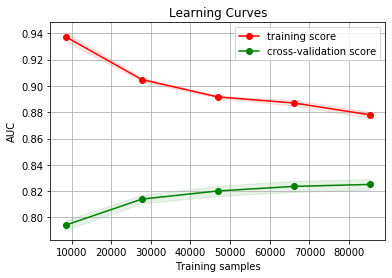

In [116]:
from sklearn.model_selection import learning_curve

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    clf,
    X_train,
    y_train,
    scoring='roc_auc',
    cv=skf.split(X_train, y_train),
    n_jobs=-1,
    train_sizes=np.linspace(.1, 1, 5),
    return_times=True)
plt.grid()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes,
         train_scores_mean,
         'o-',
         color='r',
         label='training score')
plt.plot(train_sizes,
         test_scores_mean,
         'o-',
         color='g',
         label='cross-validation score')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='r',
                 alpha=0.1)
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='g',
                 alpha=0.1)

plt.title('Learning Curves')
plt.xlabel('Training samples')
plt.ylabel('AUC')
plt.legend(loc='upper right');

In [119]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

clf.fit(X_train, y_train)
train_proba = clf.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, train_proba)

print('train AUC: ', roc_auc_score(y_train, train_proba))

#plot roc curve
fpr, tpr, thresholds_roc = roc_curve(y_train, train_proba)
precision, recall, thredsholds_pc = precision_recall_curve(y_train, train_proba)


train AUC:  0.8707308007904125


In [120]:
def plot_metrics_curve(fpr, tpr, auc, pre, rec):
    """plots roc and precision-recall curve side by side """
    plt.figure(figsize=(15,8))
    plt.xlim(-0.01,1)
    plt.ylim(0,1.01)
    
    #roc curve
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)'% auc)
    plt.plot([0,1], [0,1], linestyle='--', lw=2)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    #precision-recall
    plt.subplot(1,2,2)
    plt.plot(pre, rec, lw=2)
    plt.title('Precision-recall curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

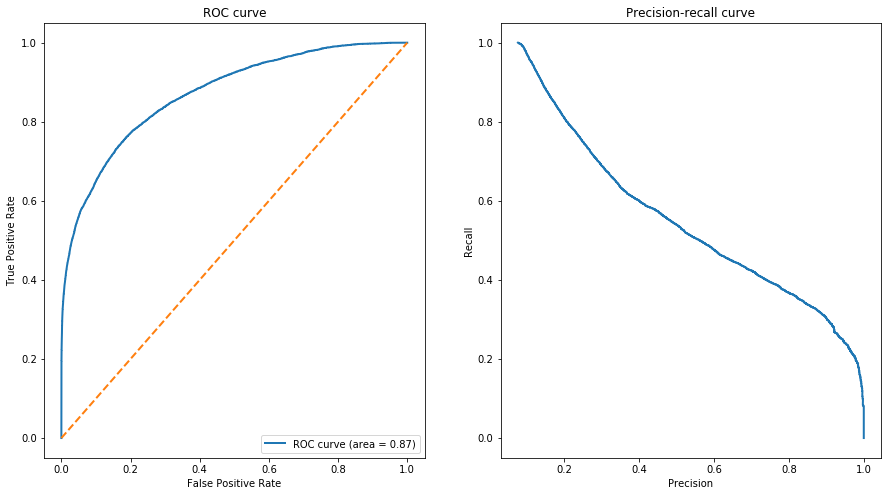

In [121]:
plot_metrics_curve(fpr, tpr, auc, precision, recall)

<a name='validation'></a>
## 4. Model Performance Validation

In [122]:
to_drop = [
    'ticket_id', 'inspector_name', 'violation_street_number',
    'violation_street_name', 'violation_zip_code',
    'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state',
    'zip_code', 'non_us_str_code', 'violation_description', 'address',
    'payment_amount', 'balance_due', 'payment_date', 'payment_status',
    'collection_status', 'compliance_detail'
]

X_test = X_test.drop(columns=to_drop)
X_test['ticket_issued_date'] = pd.to_datetime(X_test['ticket_issued_date'])
X_test['hearing_date'] = pd.to_datetime(X_test['hearing_date'])
X_test['time_diff'] = X_test['hearing_date'] - X_test['ticket_issued_date']
X_test['time_diff'] = X_test['time_diff'] / np.timedelta64(1, 'D')


X_test = cut_coordinates_into_bins(X_test, bins_lat, bins_lon)
X_test = preprocess_time_diff(X_test)
violator_names = replace_violator_name(X_test)
X_test['violator_name'] = violator_names.replace(dropped, 'other', regex=False)


X_test.loc[X_test['violator_name'].isna(), 'violator_name'] = 'other'

In [123]:
temp = X_test['violator_name']
X_test.drop(columns='violator_name', inplace=True)
X_test = X_test.assign(violator_name=temp)

In [124]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31976 entries, 18833 to 125047
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   agency_name         31976 non-null  object        
 1   country             31976 non-null  object        
 2   ticket_issued_date  31976 non-null  datetime64[ns]
 3   hearing_date        31937 non-null  datetime64[ns]
 4   violation_code      31976 non-null  object        
 5   disposition         31976 non-null  object        
 6   fine_amount         31976 non-null  float64       
 7   admin_fee           31976 non-null  float64       
 8   state_fee           31976 non-null  float64       
 9   late_fee            31976 non-null  float64       
 10  discount_amount     31976 non-null  float64       
 11  clean_up_cost       31976 non-null  float64       
 12  judgment_amount     31976 non-null  float64       
 13  grafitti_status     0 non-null      objec

In [125]:
X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [126]:
vali_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, vali_proba)

print('test AUC: ', auc)

#plot roc curve
fpr, tpr, thresholds_roc = roc_curve(y_test, vali_proba)
precision, recall, thredsholds_pc = precision_recall_curve(y_test, vali_proba)

test AUC:  0.7760771155820749


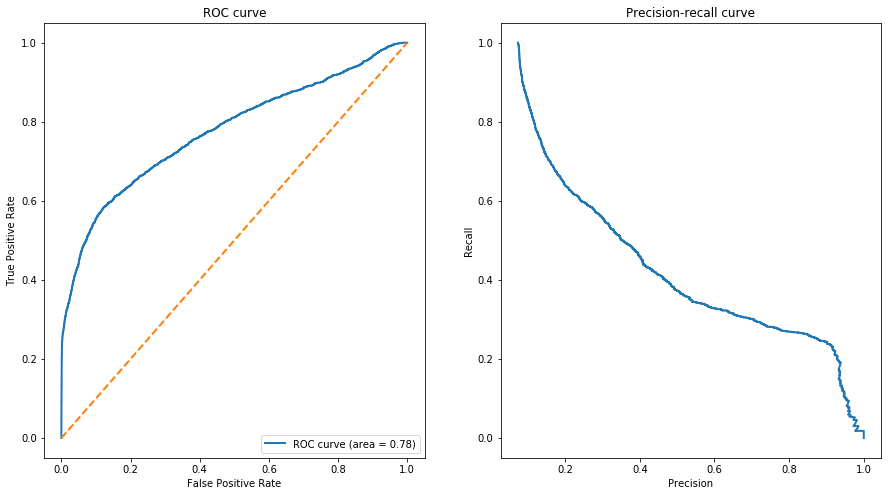

In [127]:
plot_metrics_curve(fpr, tpr, auc, precision, recall)